Scenario: 15120-TG7, Untreated, 4423, 4435, 4437, 4440, 4447, 4468, Pac+Carbo-4wk, 4430, 4431, biomarkers, 4430, 4431
Scenario: 2277-R1TG9, Untreated, 4809, 4813, 4815, 4822, 4826, 4839, Pac+Carbo-4wk, 4811, 4814, 4834, biomarkers, 4811, 4814, 4834
Scenario: 3204-R3TG5, Untreated, 4691, 4702, 4714, Pac+Carbo-4wk, 4678, 4686, 4705, biomarkers, 4678, 4686, 4705
Scenario: 4849-R1TG15, Untreated, 4301, 4315, 4332, 4362, 4364, 4373, Pac+Carbo-4wk, 4304, 4331, 4354, biomarkers, 4304, 4331, 4354
Scenario: BCM-3204, Untreated, 11, 15, 8, Pac+Carbo-4wk, 13, 28, biomarkers, 13, 28
Scenario: BMC-4175, Untreated, 6702, 6704, 6712, Pac+Carbo-4wk, 6720, 6723, biomarkers, 6720, 6723
Scenario: BRA45-R2TG8-Repeat, Untreated, 4504, 4506, 4507, 4515, Pac+Carbo-4wk, 4541, biomarkers, 4541
Scenario: HCI-034-TG11-Repeat, Untreated, 4215, 4224, 4229, 4233, 4235, 4240, Pac+Carbo-4wk, 4203, 4212, 4239, biomarkers, 4203, 4212, 4239
Scenario: MDA-BCM-IBC-103, Untreated, 6809, 6829, 6835, Pac+Carbo-4wk, 6814, 681

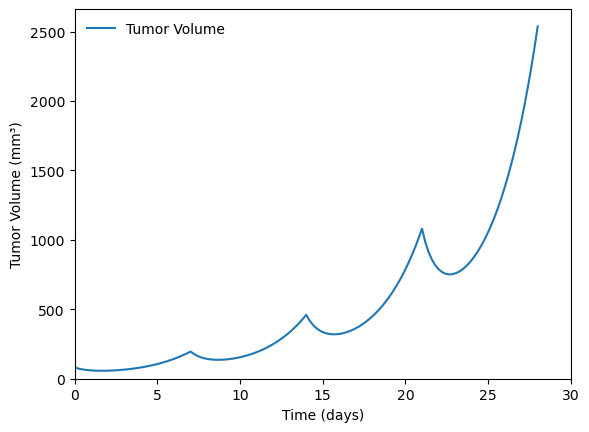

In [1]:
import glob
import numpy as np
import time
import matplotlib.pyplot as plt
from scipy.integrate import odeint

def read_data(files_location, verbose = False, number_of_data = False, filter = False, biomarkers = False):
    all_scenarios = sorted(glob.glob(files_location))
    all_data = {}

    for scn in all_scenarios:
        mouse = scn.split('_')[-1].split('.')[0]
        group = scn.split('_')[0].split('/')[-1]
        treat = scn.split('_')[2].split('/')[-1].replace("G01-", "").replace("G03-", "").replace("G06-", "").replace("-MRI-D28", "").replace("-D28", "")
        if filter and ('Paclitaxel' in treat or '1wk' in treat):
            continue
        if filter and 'Pac' in treat:
            treat = treat.replace('-4wk', '')
            treat = treat + '-4wk'

        if group not in all_data:
            all_data[group] = {}
        if treat not in all_data[group]:
            all_data[group][treat] = {}

        m_data = np.loadtxt(scn)
        if number_of_data and '4wk' in treat:
            m_data = m_data[:number_of_data]

        if biomarkers and '4wk' in treat:
            file_pattern = f'./Data/*_{mouse}.npz'
            all_files = sorted(glob.glob(file_pattern))
            if len(all_files) == 1:
                if 'biomarkers' not in all_data[group]:
                    all_data[group]['biomarkers'] = {}
                biomarkers_file = np.load(all_files[0])
                biomarkers_data = {'ADC': biomarkers_file['ADC'], 'Ktrans': biomarkers_file['Ktrans'], 'Ve': biomarkers_file['Ve']}
                all_data[group][treat][mouse] = m_data
                all_data[group]['biomarkers'][mouse] = biomarkers_data
        else:
            all_data[group][treat][mouse] = m_data

    groups_to_delete = []
    for group in all_data:
        for treat in all_data[group]:
            if len(all_data[group][treat]) == 0:
                groups_to_delete.append(group)
                break

    for group in groups_to_delete:
        del all_data[group]

    if verbose:
        for group in all_data:
            to_print = "Scenario: " + group
            for treat in all_data[group]:
                to_print += ', ' + treat
                for mouse in all_data[group][treat]:
                    to_print += ', ' + mouse
            print(to_print)

    return all_data

# Define the ODE model (non-JAX)
def model_exp_bio(y, t, growth_rate, a_treat, b_treat, tau_treat, pADC_tt, pKtr_tt, ADC, Ktrans):
    treatment = 0.0
    for tau in tau_treat:
        if tau < t:
            treatment += a_treat * np.exp(-b_treat * (t - tau))
    dydt = growth_rate * (1.0 - pADC_tt * ADC) * y - treatment * (1.0 + pKtr_tt * Ktrans) * y
    return dydt

# Load data
files_location = './Data/*_grp_*'
full_data = read_data(files_location, verbose=True, number_of_data=9, filter=True, biomarkers=True)

# Get ADC/Ktrans bounds
all_ADC, all_Ktrans = [], []
for pdx in full_data:
    if 'biomarkers' not in full_data[pdx]:
        continue
    for mouse in full_data[pdx]['biomarkers']:
        all_ADC.append(full_data[pdx]['biomarkers'][mouse]['ADC'])
        all_Ktrans.append(full_data[pdx]['biomarkers'][mouse]['Ktrans'])

all_ADC = np.array(all_ADC).flatten()
all_Ktrans = np.array(all_Ktrans).flatten()
adc_min, adc_max = np.min(all_ADC), np.max(all_ADC)
ktrans_min, ktrans_max = np.min(all_Ktrans), np.max(all_Ktrans)

print(f"ADC range:    {adc_min:.4f} to {adc_max:.4f}")
print(f"Ktrans range: {ktrans_min:.4f} to {ktrans_max:.4f}")

# RNG seed
seed = int(time.time())
seed = 1750177387 # 1750174492 # OR fixed seed for reproducibility
np.random.seed(seed)

# Sample parameters
ic          = np.random.uniform(0.0, 800.0)
growth_rate = np.random.uniform(0.0, 1.0)
a_treat     = np.random.uniform(0.0, 1.0)
b_treat     = np.random.uniform(0.0, 1.0)
tau_treat   = [0.0, 7.0, 14.0, 21.0]
pADC_tt     = np.random.uniform(0.0, 1.4)
pKtr_tt     = np.random.uniform(0.0, 2.0)
ADC         = np.random.uniform(adc_min, adc_max)
Ktrans      = np.random.uniform(ktrans_min, ktrans_max)

# Time vector
t = np.linspace(0, 28, 141)

# Integrate
y_sim = odeint(model_exp_bio, ic, t, args=(growth_rate, a_treat, b_treat, tau_treat, pADC_tt, pKtr_tt, ADC, Ktrans))

# Plot
plt.plot(t, y_sim, label='Tumor Volume')
plt.xlabel('Time (days)')
plt.ylabel('Tumor Volume (mm³)')
plt.xlim(0, 30)
plt.ylim(bottom=0)
plt.legend(fancybox=False, shadow=False, frameon=False)
plt.show()